In [23]:
import pandas as pd
import glob
import os 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
%load_ext autoreload
%autoreload 2
from helpers_barplot_intersection import reader_assign_conf_pep, plot_text, plot_intersection_bars

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# INPUTS 
read_from_disk = True # or reload
proteomicsdir = '/cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024'
#proteomicsdir = '/cluster/work/grlab/projects/projects2020_OHSU/proteomics'

pipelines = ['OHSU', 'ETH']

FDR_limit = 0.05
MS_FDR = '_crux' #choices: '_crema' '_crux' or ''
MS_strategy = 'single' #Choices: 'pool' 'joint', 'single' 

#pool: pool all experiments per pipeline
#joint: pool all experiments for both pipeline
#single: per experiment per pipeline

if MS_FDR == '_crema':
    FDR_file = 'crema.peptides.txt'
    col_seq = 'sequence'
    col_qvalue = 'crema q-value'
elif MS_FDR == '_crux' or  MS_FDR == '':
    FDR_file = 'assign-confidence.target.txt'
    col_seq = 'unmodified sequence'
    col_qvalue = 'tdc q-value'
else:
    print(f'ERROR: wrong input for {FDR_file}')

    

sample_plot_dir = {}
run_type_plot_dir = {}    
all_samples = []

# BRCA
samples = ['TCGA-C8-A12P-01A-11R-A115-07',
                  'TCGA-AO-A0JM-01A-21R-A056-07',
                  'TCGA-BH-A18V-01A-11R-A12D-07',
                  'TCGA-A2-A0D2-01A-21R-A034-07',
                  'TCGA-A2-A0SX-01A-12R-A084-07']
all_samples.extend(samples)
basedir = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102'
filter_dir = os.path.join(basedir, 'filtering_samples', 'filters_19May_order_5ge_wAnnot_GPstar')

for sample in samples:
    sample_plot_dir[sample] = os.path.join(filter_dir, 'plots')
    run_type_plot_dir[sample] = 'BRCA'
    
# OV
samples = ['TCGA-25-1319-01A-01R-1565-13',
                  'TCGA-25-1313-01A-01R-1565-13',
                  'TCGA-61-2008-01A-02R-1568-13',
                  'TCGA-24-1431-01A-01R-1566-13',
                  'TCGA-24-2298-01A-01R-1569-13']
all_samples.extend(samples)
basedir = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374'
filter_dir = os.path.join(basedir, 'filtering_samples', 'filters_19May_order_5ge_wAnnot_GPstar')

for sample in samples:
    sample_plot_dir[sample] = os.path.join(filter_dir, 'plots')
    run_type_plot_dir[sample] = 'OV'
    
    
    
# PLOTTING Parameters 
ticks_fontsize = 12
axislabels_fontsize = 12
legend_fontsize = 12
axes_fontsize = 15
save = True
sample = None

# Parse: results for all experiments

In [22]:
## Get peptides
if read_from_disk:
    samples_store_pep = {}
    samples_store_rates = {}
#     experiment_pipelines_peptides =  
#     experiments_pipelines_rates = defaultdict(dict)


    for sample in all_samples:

        sample_short = '-'.join(sample.split('-')[0:3])
        samples_store_pep[sample] = defaultdict(dict)
        samples_store_rates[sample] = defaultdict(dict)
        for pipeline in pipelines:
            path_single = os.path.join(proteomicsdir, pipeline, sample_short, 
                                       f'assign_conf_per_experiment{MS_FDR}')
            path_pool_pipeline = os.path.join(proteomicsdir, pipeline, sample_short, 
                                              f'assign_conf_pooled_FDR{MS_FDR}')
            path_pool_union = os.path.join(proteomicsdir, 
                                           f'assign_conf_joint_to_{pipeline}{MS_FDR}', sample_short)
            path_TEST_OHSU = os.path.join(proteomicsdir, 'OHSU', sample_short, 
                                       f'assign_conf_per_experiment{MS_FDR}')
            path_TEST_ETH = os.path.join(proteomicsdir, 'ETH', sample_short, 
                                       f'assign_conf_per_experiment{MS_FDR}')


            experiment_list = [ i.split('/')[-1] for i in glob.glob(path_single + '/*')] #check

            for experiment in experiment_list:
                if pipeline == 'OHSU':
                    original_name = experiment
                    cut_name = experiment[1:]
                else:
                    original_name = experiment
                    cut_name = experiment          

                if os.path.isfile(os.path.join(path_TEST_OHSU, 'J' + cut_name, FDR_file)) and \
                     os.path.isfile(os.path.join(path_TEST_ETH, cut_name, FDR_file)): #Commun experiments               

                    # search 1 experiment, 1 pipeline  
                    if MS_strategy == 'single':
                        df = os.path.join(path_single, original_name, FDR_file)
                    # search all experiments, 1 pipeline
                    if MS_strategy == 'pool':
                        df = os.path.join(path_pool_pipeline, f'tsearch-{original_name}.txt')
                    # search all experiments, 1 union of pipelines
                    if MS_strategy == 'joint':
                        df = os.path.join(path_pool_union, f'tsearch-{original_name}.txt')

                    val, val_rate, peptides, _ = reader_assign_conf_pep(df, FDR_limit, col_seq, col_qvalue)
                    samples_store_pep[sample][cut_name][pipeline] = peptides
                    samples_store_rates[sample][cut_name][pipeline] = val_rate

                    print('\n')


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/OHSU/TCGA-C8-A12P/assign_conf_per_experiment_crux/J0A53XGA/assign-confidence.target.txt
With Shape: 2373
With unique peptides: 31
Number of validated psm: (0, 17)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/OHSU/TCGA-C8-A12P/assign_conf_per_experiment_crux/J0A13AGA/assign-confidence.target.txt
With Shape: 19207
With unique peptides: 261
Number of validated psm: (0, 17)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/OHSU/TCGA-C8-A12P/assign_conf_per_experiment_crux/J0A51XGA/assign-confidence.target.txt
With Shape: 692
With unique peptides: 11
Number of validated psm: (0, 17)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects202

With Shape: 3981
With unique peptides: 53
Number of validated psm: (0, 17)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/OHSU/TCGA-C8-A12P/assign_conf_per_experiment_crux/J0AN3XGA/assign-confidence.target.txt
With Shape: 88944
With unique peptides: 1154
Number of validated psm: (0, 17)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/OHSU/TCGA-C8-A12P/assign_conf_per_experiment_crux/J02132GA/assign-confidence.target.txt
With Shape: 1885
With unique peptides: 26
Number of validated psm: (0, 17)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/OHSU/TCGA-C8-A12P/assign_conf_per_experiment_crux/J0211XGA/assign-confidence.target.txt
With Shape: 1387
With unique peptides: 15
Numb

With Shape: 4200
With unique peptides: 45
Number of validated psm: (0, 17)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/ETH/TCGA-C8-A12P/assign_conf_per_experiment_crux/0A51XGA/assign-confidence.target.txt
With Shape: 191
With unique peptides: 4
Number of validated psm: (0, 17)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/ETH/TCGA-C8-A12P/assign_conf_per_experiment_crux/02501GA/assign-confidence.target.txt
With Shape: 82
With unique peptides: 2
Number of validated psm: (0, 17)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/ETH/TCGA-C8-A12P/assign_conf_per_experiment_crux/0AN3XGA/assign-confidence.target.txt
With Shape: 3775
With unique peptides: 38
Number of validate

Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/OHSU/TCGA-AO-A0JM/assign_conf_per_experiment_crux/J0213AGA/assign-confidence.target.txt
With Shape: 3668
With unique peptides: 47
Number of validated psm: (0, 17)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/OHSU/TCGA-AO-A0JM/assign_conf_per_experiment_crux/J0AN3XGA/assign-confidence.target.txt
With Shape: 41297
With unique peptides: 566
Number of validated psm: (161, 17)
Number of validated unique peptides: 14
Validation Rate: 2.47 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/OHSU/TCGA-AO-A0JM/assign_conf_per_experiment_crux/J02132GA/assign-confidence.target.txt
With Shape: 611
With unique peptides: 9
Number of validated psm: (0, 17)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects

With Shape: 3150
With unique peptides: 42
Number of validated psm: (0, 17)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/OHSU/TCGA-BH-A18V/assign_conf_per_experiment_crux/J0AN01GA/assign-confidence.target.txt
With Shape: 32896
With unique peptides: 439
Number of validated psm: (35, 17)
Number of validated unique peptides: 9
Validation Rate: 2.05 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/OHSU/TCGA-BH-A18V/assign_conf_per_experiment_crux/J0A532GA/assign-confidence.target.txt
With Shape: 1336
With unique peptides: 19
Number of validated psm: (0, 17)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/OHSU/TCGA-BH-A18V/assign_conf_per_experiment_crux/J0A11XGA/assign-confidence.target.txt
With Shape: 3854
With unique peptides: 56
Num

With Shape: 33554
With unique peptides: 447
Number of validated psm: (39, 17)
Number of validated unique peptides: 11
Validation Rate: 2.46 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/ETH/TCGA-BH-A18V/assign_conf_per_experiment_crux/0211AGA/assign-confidence.target.txt
With Shape: 288
With unique peptides: 3
Number of validated psm: (24, 17)
Number of validated unique peptides: 2
Validation Rate: 66.67 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/ETH/TCGA-BH-A18V/assign_conf_per_experiment_crux/0211XGA/assign-confidence.target.txt
With Shape: 288
With unique peptides: 3
Number of validated psm: (24, 17)
Number of validated unique peptides: 2
Validation Rate: 66.67 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/ETH/TCGA-BH-A18V/assign_conf_per_experiment_crux/02532GA/assign-confidence.target.txt
With Shape: 114
With unique peptides: 3
Number o

With Shape: 18570
With unique peptides: 231
Number of validated psm: (0, 17)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/OHSU/TCGA-A2-A0D2/assign_conf_per_experiment_crux/J0213XGA/assign-confidence.target.txt
With Shape: 3245
With unique peptides: 38
Number of validated psm: (0, 17)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/OHSU/TCGA-A2-A0D2/assign_conf_per_experiment_crux/J0AN01GA/assign-confidence.target.txt
With Shape: 33665
With unique peptides: 422
Number of validated psm: (0, 17)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/OHSU/TCGA-A2-A0D2/assign_conf_per_experiment_crux/J0A532GA/assign-confidence.target.txt
With Shape: 794
With unique peptides: 11
Numb

With Shape: 182
With unique peptides: 2
Number of validated psm: (0, 17)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/ETH/TCGA-A2-A0D2/assign_conf_per_experiment_crux/0AN01GA/assign-confidence.target.txt
With Shape: 344
With unique peptides: 4
Number of validated psm: (0, 17)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/ETH/TCGA-A2-A0D2/assign_conf_per_experiment_crux/0AN1XGA/assign-confidence.target.txt
With Shape: 345
With unique peptides: 5
Number of validated psm: (0, 17)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/ETH/TCGA-A2-A0D2/assign_conf_per_experiment_crux/0AN32GA/assign-confidence.target.txt
With Shape: 478
With unique peptides: 8
Number of validated p

Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/OHSU/TCGA-A2-A0SX/assign_conf_per_experiment_crux/J0AN12GA/assign-confidence.target.txt
With Shape: 21788
With unique peptides: 409
Number of validated psm: (0, 17)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/OHSU/TCGA-A2-A0SX/assign_conf_per_experiment_crux/J0A11AGA/assign-confidence.target.txt
With Shape: 2733
With unique peptides: 56
Number of validated psm: (0, 17)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/OHSU/TCGA-A2-A0SX/assign_conf_per_experiment_crux/J0A101GA/assign-confidence.target.txt
With Shape: 2631
With unique peptides: 54
Number of validated psm: (0, 17)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects20

With Shape: 809
With unique peptides: 16
Number of validated psm: (0, 17)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/ETH/TCGA-A2-A0SX/assign_conf_per_experiment_crux/0A13AGA/assign-confidence.target.txt
With Shape: 1671
With unique peptides: 30
Number of validated psm: (0, 17)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/ETH/TCGA-A2-A0SX/assign_conf_per_experiment_crux/0213XGA/assign-confidence.target.txt
With Shape: 614
With unique peptides: 13
Number of validated psm: (0, 17)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/ETH/TCGA-A2-A0SX/assign_conf_per_experiment_crux/0A501GA/assign-confidence.target.txt
With Shape: 361
With unique peptides: 7
Number of validat

With Shape: 560857
With unique peptides: 16336
Number of validated psm: (870, 17)
Number of validated unique peptides: 360
Validation Rate: 2.2 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/OHSU/TCGA-25-1319/assign_conf_per_experiment_crux/J0A13AGA/assign-confidence.target.txt
With Shape: 1060981
With unique peptides: 30904
Number of validated psm: (1229, 17)
Number of validated unique peptides: 559
Validation Rate: 1.81 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/OHSU/TCGA-25-1319/assign_conf_per_experiment_crux/J0A51XGA/assign-confidence.target.txt
With Shape: 405984
With unique peptides: 11791
Number of validated psm: (532, 17)
Number of validated unique peptides: 244
Validation Rate: 2.07 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/OHSU/TCGA-25-1319/assign_conf_per_experiment_crux/J0213XGA/assign-confidence.target.txt
With Shape: 361827

With Shape: 942288
With unique peptides: 27426
Number of validated psm: (1048, 17)
Number of validated unique peptides: 465
Validation Rate: 1.7 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/OHSU/TCGA-25-1319/assign_conf_per_experiment_crux/J0A53AGA/assign-confidence.target.txt
With Shape: 571748
With unique peptides: 16647
Number of validated psm: (883, 17)
Number of validated unique peptides: 369
Validation Rate: 2.22 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/OHSU/TCGA-25-1319/assign_conf_per_experiment_crux/J02101GA/assign-confidence.target.txt
With Shape: 249816
With unique peptides: 7247
Number of validated psm: (343, 17)
Number of validated unique peptides: 155
Validation Rate: 2.14 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/OHSU/TCGA-25-1319/assign_conf_per_experiment_crux/J02112GA/assign-confidence.target.txt
With Shape: 257413
W

With Shape: 227038
With unique peptides: 6036
Number of validated psm: (385, 17)
Number of validated unique peptides: 105
Validation Rate: 1.74 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/ETH/TCGA-25-1319/assign_conf_per_experiment_crux/0253XGA/assign-confidence.target.txt
With Shape: 217112
With unique peptides: 5779
Number of validated psm: (378, 17)
Number of validated unique peptides: 101
Validation Rate: 1.75 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/ETH/TCGA-25-1319/assign_conf_per_experiment_crux/0A132GA/assign-confidence.target.txt
With Shape: 314921
With unique peptides: 8507
Number of validated psm: (529, 17)
Number of validated unique peptides: 134
Validation Rate: 1.58 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/ETH/TCGA-25-1319/assign_conf_per_experiment_crux/0213AGA/assign-confidence.target.txt
With Shape: 352331
With uniq

With Shape: 47458
With unique peptides: 1374
Number of validated psm: (126, 17)
Number of validated unique peptides: 35
Validation Rate: 2.55 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/OHSU/TCGA-25-1313/assign_conf_per_experiment_crux/J0AN3AGA/assign-confidence.target.txt
With Shape: 646056
With unique peptides: 18730
Number of validated psm: (966, 17)
Number of validated unique peptides: 372
Validation Rate: 1.99 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/OHSU/TCGA-25-1313/assign_conf_per_experiment_crux/J0A51AGA/assign-confidence.target.txt
With Shape: 166313
With unique peptides: 4815
Number of validated psm: (401, 17)
Number of validated unique peptides: 144
Validation Rate: 2.99 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/OHSU/TCGA-25-1313/assign_conf_per_experiment_crux/J0AN12GA/assign-confidence.target.txt
With Shape: 536981
With

With Shape: 537941
With unique peptides: 15594
Number of validated psm: (725, 17)
Number of validated unique peptides: 290
Validation Rate: 1.86 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/ETH/TCGA-25-1313/assign_conf_per_experiment_crux/0211AGA/assign-confidence.target.txt
With Shape: 110467
With unique peptides: 3018
Number of validated psm: (188, 17)
Number of validated unique peptides: 51
Validation Rate: 1.69 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/ETH/TCGA-25-1313/assign_conf_per_experiment_crux/0211XGA/assign-confidence.target.txt
With Shape: 110467
With unique peptides: 3018
Number of validated psm: (188, 17)
Number of validated unique peptides: 51
Validation Rate: 1.69 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/ETH/TCGA-25-1313/assign_conf_per_experiment_crux/02532GA/assign-confidence.target.txt
With Shape: 87675
With unique

With Shape: 113482
With unique peptides: 3083
Number of validated psm: (207, 17)
Number of validated unique peptides: 50
Validation Rate: 1.62 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/ETH/TCGA-25-1313/assign_conf_per_experiment_crux/02501GA/assign-confidence.target.txt
With Shape: 63450
With unique peptides: 1710
Number of validated psm: (101, 17)
Number of validated unique peptides: 19
Validation Rate: 1.11 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/ETH/TCGA-25-1313/assign_conf_per_experiment_crux/0AN3XGA/assign-confidence.target.txt
With Shape: 216875
With unique peptides: 5968
Number of validated psm: (305, 17)
Number of validated unique peptides: 89
Validation Rate: 1.49 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/ETH/TCGA-25-1313/assign_conf_per_experiment_crux/0A532GA/assign-confidence.target.txt
With Shape: 142831
With unique p

With Shape: 141820
With unique peptides: 3359
Number of validated psm: (370, 17)
Number of validated unique peptides: 96
Validation Rate: 2.86 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/OHSU/TCGA-61-2008/assign_conf_per_experiment_crux/J0AN32GA/assign-confidence.target.txt
With Shape: 2092503
With unique peptides: 50979
Number of validated psm: (3323, 17)
Number of validated unique peptides: 1034
Validation Rate: 2.03 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/OHSU/TCGA-61-2008/assign_conf_per_experiment_crux/J0A512GA/assign-confidence.target.txt
With Shape: 548069
With unique peptides: 13256
Number of validated psm: (1476, 17)
Number of validated unique peptides: 373
Validation Rate: 2.81 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/OHSU/TCGA-61-2008/assign_conf_per_experiment_crux/J0A112GA/assign-confidence.target.txt
With Shape: 11144

With Shape: 471142
With unique peptides: 10959
Number of validated psm: (1376, 17)
Number of validated unique peptides: 214
Validation Rate: 1.95 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/ETH/TCGA-61-2008/assign_conf_per_experiment_crux/0A501GA/assign-confidence.target.txt
With Shape: 288454
With unique peptides: 6818
Number of validated psm: (859, 17)
Number of validated unique peptides: 141
Validation Rate: 2.07 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/ETH/TCGA-61-2008/assign_conf_per_experiment_crux/0A11AGA/assign-confidence.target.txt
With Shape: 348872
With unique peptides: 8280
Number of validated psm: (975, 17)
Number of validated unique peptides: 166
Validation Rate: 2.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/ETH/TCGA-61-2008/assign_conf_per_experiment_crux/0AN01GA/assign-confidence.target.txt
With Shape: 357147
With uni

With Shape: 165953
With unique peptides: 3905
Number of validated psm: (530, 17)
Number of validated unique peptides: 80
Validation Rate: 2.05 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/ETH/TCGA-61-2008/assign_conf_per_experiment_crux/02112GA/assign-confidence.target.txt
With Shape: 292151
With unique peptides: 6922
Number of validated psm: (828, 17)
Number of validated unique peptides: 135
Validation Rate: 1.95 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/OHSU/TCGA-24-1431/assign_conf_per_experiment_crux/J0A53XGA/assign-confidence.target.txt
With Shape: 304950
With unique peptides: 8123
Number of validated psm: (906, 17)
Number of validated unique peptides: 265
Validation Rate: 3.26 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/OHSU/TCGA-24-1431/assign_conf_per_experiment_crux/J0A13AGA/assign-confidence.target.txt
With Shape: 530716
With u

With Shape: 61416
With unique peptides: 1596
Number of validated psm: (204, 17)
Number of validated unique peptides: 59
Validation Rate: 3.7 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/OHSU/TCGA-24-1431/assign_conf_per_experiment_crux/J0A132GA/assign-confidence.target.txt
With Shape: 460874
With unique peptides: 12408
Number of validated psm: (1050, 17)
Number of validated unique peptides: 336
Validation Rate: 2.71 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/OHSU/TCGA-24-1431/assign_conf_per_experiment_crux/J0A53AGA/assign-confidence.target.txt
With Shape: 312258
With unique peptides: 8313
Number of validated psm: (932, 17)
Number of validated unique peptides: 272
Validation Rate: 3.27 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/OHSU/TCGA-24-1431/assign_conf_per_experiment_crux/J02101GA/assign-confidence.target.txt
With Shape: 145106
With

With Shape: 154256
With unique peptides: 3894
Number of validated psm: (247, 17)
Number of validated unique peptides: 70
Validation Rate: 1.8 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/ETH/TCGA-24-1431/assign_conf_per_experiment_crux/0253XGA/assign-confidence.target.txt
With Shape: 146338
With unique peptides: 3677
Number of validated psm: (227, 17)
Number of validated unique peptides: 64
Validation Rate: 1.74 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/ETH/TCGA-24-1431/assign_conf_per_experiment_crux/0A132GA/assign-confidence.target.txt
With Shape: 194164
With unique peptides: 4966
Number of validated psm: (419, 17)
Number of validated unique peptides: 88
Validation Rate: 1.77 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/ETH/TCGA-24-1431/assign_conf_per_experiment_crux/0213AGA/assign-confidence.target.txt
With Shape: 224615
With unique p

With Shape: 118343
With unique peptides: 3268
Number of validated psm: (219, 17)
Number of validated unique peptides: 75
Validation Rate: 2.29 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/OHSU/TCGA-24-2298/assign_conf_per_experiment_crux/J0AN3AGA/assign-confidence.target.txt
With Shape: 1904049
With unique peptides: 54054
Number of validated psm: (2211, 17)
Number of validated unique peptides: 952
Validation Rate: 1.76 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/OHSU/TCGA-24-2298/assign_conf_per_experiment_crux/J0A51AGA/assign-confidence.target.txt
With Shape: 455732
With unique peptides: 12734
Number of validated psm: (785, 17)
Number of validated unique peptides: 303
Validation Rate: 2.38 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/OHSU/TCGA-24-2298/assign_conf_per_experiment_crux/J0AN12GA/assign-confidence.target.txt
With Shape: 1594292

With Shape: 1596779
With unique peptides: 45422
Number of validated psm: (1704, 17)
Number of validated unique peptides: 757
Validation Rate: 1.67 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/ETH/TCGA-24-2298/assign_conf_per_experiment_crux/0211AGA/assign-confidence.target.txt
With Shape: 289599
With unique peptides: 7645
Number of validated psm: (261, 17)
Number of validated unique peptides: 99
Validation Rate: 1.29 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/ETH/TCGA-24-2298/assign_conf_per_experiment_crux/0211XGA/assign-confidence.target.txt
With Shape: 289599
With unique peptides: 7645
Number of validated psm: (261, 17)
Number of validated unique peptides: 99
Validation Rate: 1.29 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/ETH/TCGA-24-2298/assign_conf_per_experiment_crux/02532GA/assign-confidence.target.txt
With Shape: 210681
With uni

With Shape: 293376
With unique peptides: 7757
Number of validated psm: (332, 17)
Number of validated unique peptides: 121
Validation Rate: 1.56 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/ETH/TCGA-24-2298/assign_conf_per_experiment_crux/02501GA/assign-confidence.target.txt
With Shape: 163101
With unique peptides: 4362
Number of validated psm: (171, 17)
Number of validated unique peptides: 57
Validation Rate: 1.31 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/ETH/TCGA-24-2298/assign_conf_per_experiment_crux/0AN3XGA/assign-confidence.target.txt
With Shape: 524986
With unique peptides: 14055
Number of validated psm: (663, 17)
Number of validated unique peptides: 215
Validation Rate: 1.53 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/ETH/TCGA-24-2298/assign_conf_per_experiment_crux/0A532GA/assign-confidence.target.txt
With Shape: 355161
With uniq

In [24]:
## Compare peptides
if read_from_disk:
    compare = {'sample' : [], 
              'filter_' : [], 
              'pep_size_ohsu' : [], 
              'pep_size_eth' : [], 
              'pep_size_intersection' : [], 
              'pep_size_ohsu\eth' : [], 
              'pep_size_eth\ohsu' : []}

    for sample, experiments_ in samples_store_pep.items():
        for experiment, pipelines_ in experiments_.items():
            if ('OHSU' in pipelines_.keys()) and ('ETH' in pipelines_.keys()):
                compare['sample'].append(sample)
                compare['filter_'].append(experiment)
                compare['pep_size_ohsu'].append(len(pipelines_['OHSU']))
                compare['pep_size_eth'].append(len(pipelines_['ETH']))
                compare['pep_size_ohsu\eth'].append(len(pipelines_['OHSU'].difference(pipelines_['ETH'])))
                compare['pep_size_eth\ohsu'].append(len(pipelines_['ETH'].difference(pipelines_['OHSU'])))
                compare['pep_size_intersection'].append(len(pipelines_['ETH'].intersection(pipelines_['OHSU'])))

# Plot: Results per experiment

In [56]:
# Choose plotting sample
sample = 'TCGA-25-1319-01A-01R-1565-13'
sample =  'TCGA-AO-A0JM-01A-21R-A056-07'

In [57]:
if read_from_disk:
    df = pd.DataFrame(compare)
    display(df.head())
    print(df.shape)
else:
    df = None

,sample,filter_,pep_size_ohsu,pep_size_eth,pep_size_intersection,pep_size_ohsu\eth,pep_size_eth\ohsu
0,TCGA-C8-A12P-01A-11R-A115-07,0A53XGA,0,0,0,0,0
1,TCGA-C8-A12P-01A-11R-A115-07,0A13AGA,0,0,0,0,0
2,TCGA-C8-A12P-01A-11R-A115-07,0A51XGA,0,0,0,0,0
3,TCGA-C8-A12P-01A-11R-A115-07,0213XGA,0,0,0,0,0
4,TCGA-C8-A12P-01A-11R-A115-07,0AN01GA,0,0,0,0,0


(330, 7)


In [58]:
def run_sample_plotting(sample_plot_dir, sample, df, MS_FDR, MS_strategy, save):
    order_file = os.path.join(sample_plot_dir[sample], f'{sample}_Barplot_sorting.tsv.gz')
    order_file = pd.read_csv(order_file, sep = '\t')
    display(order_file.head())
    print(order_file.shape)
    df_plot = order_file.merge(df, on = ['sample', 'filter_'], how = 'inner')
    df_plot = df_plot.fillna(0)
    print(df_plot.shape)
    df_plot = df_plot.sort_values('index')
    display(df_plot.head())
    # Plotting
    run_type = run_type_plot_dir[sample]

    back_ticks = df_plot['filter_background'] 
    front_ticks = df_plot['filter_foreground']

    serie_index = df_plot['index']
    serie_intersection = df_plot['pep_size_intersection']
    serie_eth = df_plot['pep_size_eth']
    print(serie_eth)
    serie_ohsu = df_plot['pep_size_ohsu']
    y_label = 'Number of MS-detected tryptic junction-peptides'

    name_plot = f'Barplot_ovelap_protein{MS_FDR}_{MS_strategy}'
    base_plot = sample
    plot_dir = sample_plot_dir[sample]

    plot_intersection_bars(back_ticks, front_ticks, ticks_fontsize, axislabels_fontsize, 
                              legend_fontsize, axes_fontsize, run_type, 
                               serie_index, serie_intersection, serie_eth, serie_ohsu,
                               y_label, save, plot_dir, base_plot, name_plot)
    return df_plot

/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/data_crux_single.tsv.gz


,sample,filter_,size_ohsu,size_eth,size_intersection,size_ohsu\eth,size_eth\ohsu,filter_foreground_target,filter_foreground_reads,filter_foreground_samples,filter_background_reads,filter_background_samples,cohort,motif,index,filter_background,filter_foreground
0,TCGA-AO-A0JM-01A-21R-A056-07,02501GA,0,0,0,0,0,0,2,5,0,1,G,A,0,"(0, 1)","(0, 2, 5)"
1,TCGA-AO-A0JM-01A-21R-A056-07,02512GA,0,0,0,0,0,0,2,5,1,2,G,A,1,"(1, 2)","(0, 2, 5)"
2,TCGA-AO-A0JM-01A-21R-A056-07,0251AGA,0,0,0,0,0,0,2,5,1,A,G,A,2,"(1, A)","(0, 2, 5)"
3,TCGA-AO-A0JM-01A-21R-A056-07,0251XGA,0,0,0,0,0,0,2,5,1,X,G,A,3,"(1, X)","(0, 2, 5)"
4,TCGA-AO-A0JM-01A-21R-A056-07,0A501GA,5,6,0,5,6,0,A,5,0,1,G,A,4,"(0, 1)","(0, A, 5)"


(35, 17)
(27, 22)


,sample,filter_,size_ohsu,size_eth,size_intersection,size_ohsu\eth,size_eth\ohsu,filter_foreground_target,filter_foreground_reads,filter_foreground_samples,...,cohort,motif,index,filter_background,filter_foreground,pep_size_ohsu,pep_size_eth,pep_size_intersection,pep_size_ohsu\eth,pep_size_eth\ohsu
0,TCGA-AO-A0JM-01A-21R-A056-07,02532GA,33,32,13,20,19,0,2,5,...,G,A,8,"(3, 2)","(0, 2, 5)",0,0,0,0,0
1,TCGA-AO-A0JM-01A-21R-A056-07,0A532GA,47,39,13,34,26,0,A,5,...,G,A,9,"(3, 2)","(0, A, 5)",0,0,0,0,0
2,TCGA-AO-A0JM-01A-21R-A056-07,02101GA,53,28,14,39,14,0,2,1,...,G,A,10,"(0, 1)","(0, 2, 1)",0,0,0,0,0
3,TCGA-AO-A0JM-01A-21R-A056-07,02112GA,53,28,14,39,14,0,2,1,...,G,A,11,"(1, 2)","(0, 2, 1)",0,0,0,0,0
4,TCGA-AO-A0JM-01A-21R-A056-07,0211AGA,53,28,14,39,14,0,2,1,...,G,A,12,"(1, A)","(0, 2, 1)",0,0,0,0,0


0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
Name: pep_size_eth, dtype: int64
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_ovelap_protein_crux_single.pdf
Saving!


/scratch/slurm-job.4141443/ipykernel_2085930/2131909032.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, axis = 'both', which='major', color=colorgrid, linestyle='-', alpha=alpha_grid)
/scratch/slurm-job.4141443/ipykernel_2085930/2131909032.py:26: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False, axis = 'both', which='minor', color=colorgrid, linestyle='--', alpha=alpha_grid)
/scratch/slurm-job.4141443/ipykernel_2085930/2131909032.py:26: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=colorgrid, linestyle='--', alpha=alpha_grid)


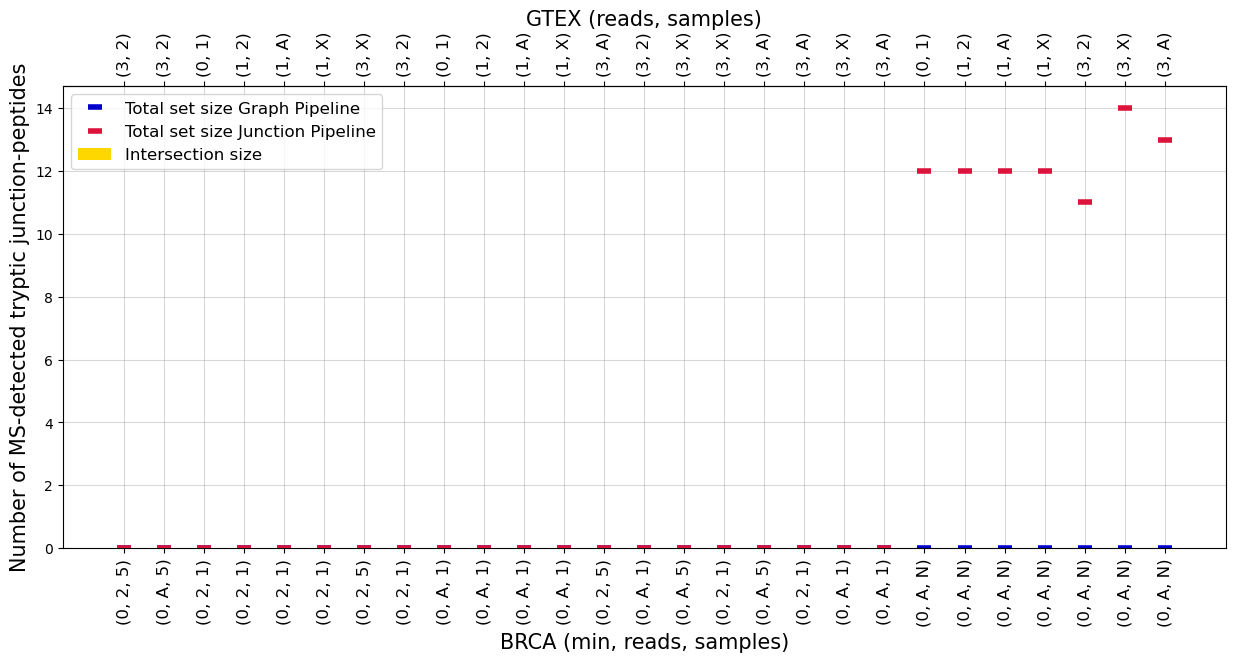

In [79]:
# TMP CODE single sample
save = True
path_data = os.path.join(sample_plot_dir[sample], f'data{MS_FDR}_{MS_strategy}.tsv.gz')
print(path_data)
if df is not None:
    df.to_csv(path_data, sep = '\t', index = None)
else:
    df = pd.read_csv(path_data, sep = '\t')
df_plot = run_sample_plotting(sample_plot_dir, sample, df, MS_FDR, MS_strategy, save)

In [ ]:
# for sample in all_samples:
#     path_data = os.path.join(sample_plot_dir[sample], f'data{MS_FDR}_{MS_strategy}.tsv.gz')
#     print(path_data)
#     if df is not None:
#         df.to_csv(path_data, sep = '\t', index = None)
#     else:
#         df = pd.read_csv(path_data, sep = '\t')
#     run_sample_plotting(sample_plot_dir, sample, df, MS_FDR, MS_strategy, save)